In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from typing import Any, Dict, Optional, List, Tuple
from mlagents.trainers.models import EncoderType

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
from mlagents.trainers.models import ModelUtils

In [4]:
from mlagents.tf_utils import tf
from mlagents import tf_utils

In [5]:
def create_encoder(
    visual_in: List[tf.Tensor],
    vector_in: tf.Tensor,
    h_size: int,
    feature_size: int,
    num_layers: int,
    vis_encode_type: EncoderType,
) -> tf.Tensor:
    with tf.variable_scope("encoding"):
        hidden_stream = ModelUtils.create_observation_streams(
            visual_in,
            vector_in,
            1,
            h_size,
            num_layers,
            vis_encode_type,
        )[0]

        latent = tf.layers.dense(
                hidden_stream,
                feature_size,
                name="latent",
                activation=ModelUtils.swish,
                kernel_initializer=tf.initializers.variance_scaling(1.0),
            )
    return latent

In [10]:
def load_encoder(path, sess, variables):
    saver = tf.train.Saver(variables)
    checkpoint = os.path.join(path, f"encoding.ckpt")
    saver.restore(sess, checkpoint)
    print("loaded from path", path)

In [11]:
h_size = 32
feature_size = 2
num_layers = 1
vis_encode_type = "simple"
input_size = 4

In [12]:
graph = tf.Graph()
sess = tf.Session(config=tf_utils.generate_session_config(), graph=graph)
with graph.as_default():
    vector_in = ModelUtils.create_vector_input(input_size)
    encoder = create_encoder([], vector_in, h_size, feature_size, num_layers, vis_encode_type)
    print(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
    load_encoder("./transfer_results/model_normal_s0/Simple", sess, 
            tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoding"))

[<tf.Variable 'encoding/main_graph_0/hidden_0/kernel:0' shape=(4, 32) dtype=float32_ref>, <tf.Variable 'encoding/main_graph_0/hidden_0/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'encoding/latent/kernel:0' shape=(32, 2) dtype=float32_ref>, <tf.Variable 'encoding/latent/bias:0' shape=(2,) dtype=float32_ref>]
INFO:tensorflow:Restoring parameters from ./transfer_results/model_normal_s0/Simple/encoding.ckpt
loaded from path ./transfer_results/model_normal_s0/Simple


In [17]:
with graph.as_default():
    print(sess.run(encoder, feed_dict={vector_in: [[1., 1., 1., 1.]]}))

[[-0.00607633 -0.0811841 ]]


In [59]:
from matplotlib.colors import LinearSegmentedColormap

def bluegreen(y):
    red = [(0.0, 0.0, 0.0), (0.5, y, y), (1.0, 0.0, 0.0)]
    green = [(0.0, 0.0, 0.0), (0.5, y, y), (1.0, y, y)]
    blue = [(0.0, y, y), (0.5, y, y),(1.0,0.0,0.0)]
    colordict = dict(red=red, green=green, blue=blue)
    bluegreenmap = LinearSegmentedColormap('bluegreen', colordict, 256)
    return bluegreenmap

def my_color(i,j):
    return (i, j, max(0,1-i-j))

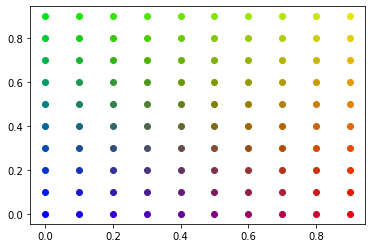

In [62]:
x = np.arange(0,1,0.1)
y = np.arange(0,1,0.1)
for i in x:
    for j in y:
        plt.scatter(i, j, color=my_color(i,j))
plt.show()

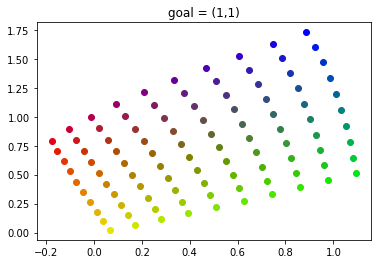

In [66]:
with graph.as_default():
    for i in x:
        for j in y:
            encoded = sess.run(encoder, feed_dict={vector_in: [[1., 1., i, j]]})
            plt.scatter(encoded[0][0], encoded[0][1], color=my_color(i,j))
plt.title("goal = (1,1)")
plt.show()

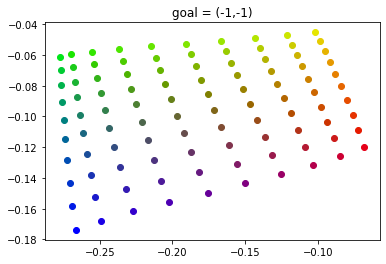

In [67]:
with graph.as_default():
    for i in x:
        for j in y:
            encoded = sess.run(encoder, feed_dict={vector_in: [[-1., -1., i, j]]})
            plt.scatter(encoded[0][0], encoded[0][1], color=my_color(i,j))
plt.title("goal = (-1,-1)")
plt.show()

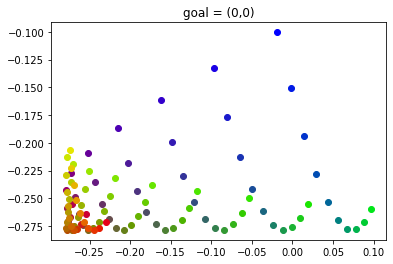

In [68]:
with graph.as_default():
    for i in x:
        for j in y:
            encoded = sess.run(encoder, feed_dict={vector_in: [[0, 0, i, j]]})
            plt.scatter(encoded[0][0], encoded[0][1], color=my_color(i,j))
plt.title("goal = (0,0)")
plt.show()

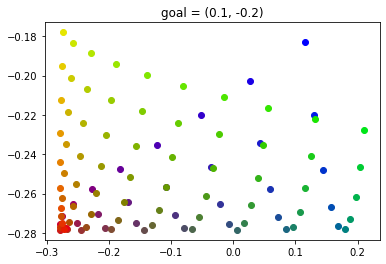

In [69]:
with graph.as_default():
    for i in x:
        for j in y:
            encoded = sess.run(encoder, feed_dict={vector_in: [[0.1, -0.2, i, j]]})
            plt.scatter(encoded[0][0], encoded[0][1], color=my_color(i,j))
plt.title("goal = (0.1, -0.2)")
plt.show()